# Loading and Aligning the Datasets
## There have been no significant changes in the following code:

In [2]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
violations = pd.read_csv(
    'data/AllViolations.csv', 
    parse_dates = ['date'], 
    infer_datetime_format = True,
    index_col = 0
)

In [4]:
import json
from pandas.io.json import json_normalize

with open('data/yelp_academic_dataset_business.json', 'r') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = '[' + (',').join(data) + ']'

business = pd.read_json(data_json_str)
business = business[[
    'name',
    'full_address',
    'city',
    'business_id',
    'review_count', 
    'stars',
    'latitude',
    'longitude'
]]
business.columns = [
    'name',     
    'address',
    'city',
    'yelp_id',
    'reviews',
    'rating',
    'latitude',
    'longitude'
]

%reset_selective -f data_json_str
%reset_selective -f data

In [5]:
idtable = pd.read_csv(
    'data/restaurant_ids_to_yelp_ids.csv'
)
idtable = pd.concat([
        idtable[['restaurant_id','yelp_id_0']].rename(columns = {'yelp_id_0':'yelp_id'}),
        idtable[idtable.yelp_id_1.notnull()][['restaurant_id','yelp_id_1']].rename(columns = {'yelp_id_1':'yelp_id'}),
        idtable[idtable.yelp_id_2.notnull()][['restaurant_id','yelp_id_2']].rename(columns = {'yelp_id_2':'yelp_id'}),
        idtable[idtable.yelp_id_3.notnull()][['restaurant_id','yelp_id_3']].rename(columns = {'yelp_id_3':'yelp_id'})
], ignore_index = True)

In [ ]:
violations = violations.merge(
    idtable, 
    on = 'restaurant_id'
).merge(
    business, 
    on = 'yelp_id'
).drop(['yelp_id', 'address', 'city'], 1)
violations = violations[violations.date >= '2011-08-01'].sort_values('date')

In [ ]:
services = pd.read_csv(
    'data/311__Service_Requests.csv', 
    usecols = [
       'OPEN_DT', 'CLOSED_DT', 'CASE_STATUS', 'CLOSURE_REASON', 'CASE_TITLE', 'SUBJECT', 'REASON',
       'TYPE', 'LATITUDE', 'LONGITUDE'
    ],
    parse_dates=['OPEN_DT', 'CLOSED_DT'], 
    infer_datetime_format = True
)
services.columns = [
    'open',         # date the complaint was registered
    'closed',       # date the complaint was resolved
    'status',       # open or closed
    'closure',      # details of how the complaint was closed (NaN if open)
    'title',        # description of the issue
    'subject',      # category of the issue (e.g. public works, civil rights, animal control, etc.)
    'reason',       # more specific category (often very similar to the "title")
    'type',         # usually identical to the "title" 
    'latitude',      
    'longitude'      
]
services = services.sort_values(['open', 'reason'])

In [8]:
reason = services.reason.value_counts().head(45).reset_index()['index']

In [9]:
violations.to_pickle('data/violations.pkl')
business.to_pickle('data/business.pkl')
idtable.to_pickle('data/idtable.pkl')
services.to_pickle('data/services.pkl')
reason.to_pickle('data/reason.pkl')

In [ ]:
pd.options.mode.chained_assignment = None
for j in range(45):
    violations[reason[j]] = nan

violations['delay'] = nan
    
for row in range(len(violations)):
    c = (violations.latitude.iloc[row], violations.longitude.iloc[row])
    ri = violations.restaurant_id.iloc[row]
    t = violations.date.iloc[row]
    tlast = violations[(violations.date <= t - timedelta(days = 1)) & (violations.restaurant_id == ri)].date.max()
    violations['delay'].iloc[row] = t - tlast
    s = services[
            (services.open < t - timedelta(days = 5)) &
            (services.open > t - timedelta(days = 15)) &
            ((services.latitude - c[0])**2 + (services.longitude - c[1])**2 < .0025)
    ]
    violations.iloc[row,10:55] = s.groupby('reason').count().iloc[:,0][reason].fillna(0).values
        
violations['delay'] = (violations.delay) / (timedelta(days=1))
violations['delay'] = violations.delay.astype(float)

In [11]:
violations.to_pickle('data/violations.pkl')

In [12]:
%reset_selective -f business
%reset_selective -f services

In [ ]:
reviews = pd.DataFrame()
with open('data/yelp_academic_dataset_review.json', 'r') as f:
    for line in f:
        df = pd.read_json(line).set_index('review_id').iloc[[0]].drop(['user_id','votes','type'], axis=1)
        reviews = reviews.append(df)
reviews = reviews.rename(
    columns = {'business_id':'yelp_id'}
).merge(
    idtable, 
    on = 'yelp_id'
).drop(
    'yelp_id', 
    axis = 1
)
reviews[['date']] = pd.to_datetime(reviews.date)

In [14]:
reviews.to_pickle('data/reviews.pkl')

In [15]:
for row in range(len(violations)):
    ri = violations.restaurant_id.iloc[row]
    t = violations.date.iloc[row]
    r = reviews[
        (reviews.restaurant_id == ri) &
        (reviews.date <= t - timedelta(days = 5)) &
        (reviews.date >= t - timedelta(days = 365))
    ]
    violations['rating'].iloc[row] = r.stars.mean()
    violations['reviews'].iloc[row] = r['text'].astype(str).str.cat(sep=' ')

In [16]:
violations.to_pickle('data/violations.pkl')

In [17]:
violations['rating'] = violations.rating.fillna(5)
violations = violations[violations.delay > 45]
violations = violations.drop(['latitude','longitude'], axis=1)

In [18]:
%reset_selective -f reviews
%reset_selective -f idtable

---
# Building a first predictive model
## First, a naive Bayes classifier based on textual reviews:

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [20]:
vectorizer = CountVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (2,4))

X1 = vectorizer.fit_transform(violations.reviews).tocsc()
y = (violations['*'] + violations['**'] + violations['***'] > 0).values.astype(np.int)
X2 = violations.iloc[:,7:53]

X1train, X1test, X2train, X2test, ytrain, ytest = train_test_split(X1, X2, y, train_size=.8)

clf1 = MultinomialNB(alpha = 5)
clf1.fit(X1train, ytrain)
clf1.score(X1train, ytrain), clf1.score(X1test, ytest)

(0.75239664469742362, 0.64071856287425155)

## The probabilities from the naive Bayes classifier are now used as one of the features of a logistic regression classifier:

In [21]:
from sklearn.linear_model import LogisticRegression
X2train['text'] = clf1.predict_proba(X1train)[:,1]
X2test['text'] = clf1.predict_proba(X1test)[:,1]
clf2 = LogisticRegression(C = 8)
clf2.fit(X2train, ytrain)
clf2.score(X2train, ytrain), clf2.score(X2test, ytest)

(0.89289994008388252, 0.81437125748502992)

### Accuracies on training and test data are shown above.
## The ROC curve and AUC:

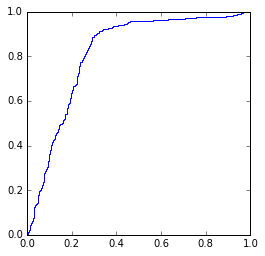

In [22]:
from sklearn.metrics import roc_curve
plt.rcParams['figure.figsize'] = (4, 4)
xroc, yroc, _ = roc_curve(ytest, clf2.predict_proba(X2test)[:,1])
plt.plot(xroc, yroc)
None

In [23]:
from sklearn.metrics import auc
auc(xroc,yroc)

0.81721117076040595

## The precision-recall curve and corresponding AUC:

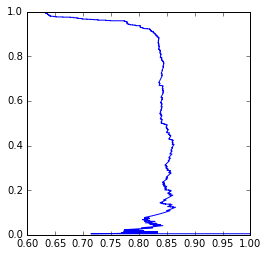

In [24]:
from sklearn.metrics import precision_recall_curve
xprc, yprc, _ = precision_recall_curve(ytest, clf2.predict_proba(X2test)[:,1])
plt.plot(xprc, yprc)
None

In [25]:
auc(yprc,xprc)

0.83432111734590175